# Classification
## MI201

##**Group 4** :
- Diego FLEURY CORRÊA DE MORAES
- Hazael SOLEDADE DE ARAUJO JUMONJI
- Lucas DE OLIVEIRA MARTIM

### Project 3 : **Sentiment Analysis Using LLMs**

In [1]:
! git clone https://github.com/DiegoFleury/MI201-groupe-4.git

Cloning into 'MI201-groupe-4'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 204 (delta 0), reused 0 (delta 0), pack-reused 198 (from 2)
Receiving objects: 100% (204/204), 227.34 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Updating files: 100% (21/21), done.


# Introduction

We've decided to separate this notebook on a per-model basis. The data structures and approaches to each of the segments is way too heterogenous to attempt to unify them all under a single procedure, in a manner that's neither unrepresentative nor forced.

The notebook is divided in 3 main parts. The first 2 represent each
one form of LLM usage (Feature-based or Finetuned) based upon the ideas
discussed in the paper :

- **Feature-based**
  - Classical Machine Learning
  - Neural Networks
- **Finetuning-based**
  - BERT and roBERTa (*Classical Finetuning*)
  - BERT and roBERTa (*LoRA Finetuning*)

In order to provide a richer discussion, we've also added a third section, in which we used an API to get predictions from bigger LLM models. This has the goal of not only serving as a base for comparison, but also getting an idea on how good really can a model actually perform on the dataset.

- **Deepseek v3**

With this, we hope to have been able to show the differences between each approach.

# Importing and Installing libraries

In [2]:
! pip install umap-learn numba llamaapi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.2 MB/s eta 0:00:00


In [45]:
# Data handling
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import unicodedata

# BERT
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer

# Deep learning
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Dimensionality reduction
import umap
import numba

# Classic ML models
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

# LLM API
import json
from llamaapi import LlamaAPI
import time

# LoRA
from peft import LoraConfig, get_peft_model, TaskType
from transformers import TrainingArguments
import os

# Data Handling

Let's take the already processed datasets, a result of the preProcessingAndEDA notebook.

## Initializing the DataFrames

In [4]:
data_path = "MI201-groupe-4/Data/"

In [5]:
# Load the data
train_full = pd.read_csv(data_path + 'processed_train.csv')
test_full =  pd.read_csv(data_path + 'processed_test.csv')

# Drop any null values
train_full.dropna(inplace=True)
test_full.dropna(inplace=True)

# Perform the proper separation of functions of each dataset
X_train, X_val, y_train, y_val = train_test_split(train_full['Text'], train_full['Sentiment'], test_size=0.2, random_state=42)
X_test, y_test = test_full['Text'], test_full['Sentiment']

# Correct the indexes of all tables
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

## Preprocessing the DataFrames

In [6]:
# Preprocessing the text, just enough to not lose any important features

def preprocess_text(text):
    """
    Text preprocessing, removing accents, links, HTML, extra spaces and user names.

    - Converts to lowercase.
    - Removes accents.
    - Removes HTML tags.
    - Remove links (http, https, www).
    - Removes extra spaces.
    - Removes user names.
    """

    if not isinstance(text, str):
        return ""

    # Lowercase
    text = text.lower()

    # Strip all accents
    text = ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

    # Removes links (http, https, www)
    text = re.sub(r"http\S+|www\S+", "", text)

    # Removes HTML tags
    text = re.sub(r"<.*?>", "", text)

    # Removes usernames
    text = re.sub(r"@\w+", "", text)

    # Removes line breaks and excessive whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Also need to preprocess the labels. Mapping made like this to preserve
# the ordinal character of the feature. Also, isn't zero-centered
# due to the input requirements of XGBoost
sentiment_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}

In [7]:
# Apply the preprocessing to the features
X_train = X_train.apply(preprocess_text)
X_val = X_val.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [8]:
X_train

,Text
0,"oh, he`s hilarious. i`m just commenting on the..."
1,"thanks for trying i was hoping bud trillin, bu..."
2,after show at our house rocked! saying goodbye...
3,up at 4:30am west coast time..gettin ready to ...
4,my computer is so slooowww this morning. i thi...
...,...
21979,feels like warm things
21980,my best friend is in vegas without me
21981,- fire and urban at rock challenge
21982,a+ for effort though


In [9]:
# Apply the preprocessing to the labels
y_train = y_train.map(sentiment_mapping)
y_val = y_val.map(sentiment_mapping)
y_test = y_test.map(sentiment_mapping)

In [10]:
y_train

,Sentiment
0,2
1,2
2,1
3,2
4,1
...,...
21979,1
21980,1
21981,1
21982,2


## Creating Pytorch Data Objects

In [11]:
# Custom Dataset object created to store the original texts
# and return them in the form of it's tokenizer's parameters (ids, attention mask) and label
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (DataFrame): DataFrame with the text samples.
            labels (DataFrame): DataFrame of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

In [12]:
# Custom Dataset object created to store the embedded version of each text ()
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (numpy array): Representation of embedding of the hole text ([CLS] token with context).
            labels (DataFrame): DataFrame of sentiment labels (e.g., 0, 1).
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings,
            "label": torch.tensor(label, dtype=torch.long)
        }

In [13]:
# Extract embeddings for all data
# effectively converting from one representation (Text) to the other (Embedding)
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

In [14]:
# Hyperparameters
PRETRAINED_MODEL = "cardiffnlp/twitter-roberta-base-sentiment" # "bert-base-uncased"
MAX_LENGTH = 256 # Tweets can have at most 280 characters, but let's keep it a power of 2
BATCH_SIZE = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

# Initialize the datasets
train_dataset = TextDataset(X_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(X_test, y_test, tokenizer, MAX_LENGTH)

# Initialize the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [15]:
def process_embeddings(extract_embeddings, data_loader, model_name, device, file_path):
    """
    Processes embeddings for a given dataset.

    If file_path exists, loads embeddings from the file.
    Otherwise, extracts embeddings using the model and saves them.

    Args:
        extract_embeddings: Function to extract embeddings.
        data_loader: DataLoader for the dataset.
        model_name: Name of the pre-trained model.
        device: Execution device (cuda or cpu).
        file_path: Path to save or load embeddings.

    Returns:
        embeddings : Matrix of size (number_of_samples, embedding_size).
    """
    if file_path:
        try:
            embeddings = np.load(file_path)
            return embeddings
        except FileNotFoundError:
            pass

    # Load model
    bert = AutoModel.from_pretrained(model_name).to(device)

    # Extract embeddings
    embeddings = extract_embeddings(bert, data_loader, device).cpu().numpy()

    # Save embeddings
    np.save(file_path, embeddings)

    return embeddings

In [16]:
train_embeddings = process_embeddings(extract_embeddings, train_loader, PRETRAINED_MODEL, device, data_path + "roberta_train_embeddings.npy")
val_embeddings = process_embeddings(extract_embeddings, val_loader, PRETRAINED_MODEL, device,     data_path + "roberta_val_embeddings.npy")
test_embeddings = process_embeddings(extract_embeddings, test_loader, PRETRAINED_MODEL, device,   data_path + "roberta_test_embeddings.npy")

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
train_embeddings.shape, val_embeddings.shape, test_embeddings.shape

((21984, 768), (5496, 768), (3534, 768))

In [18]:
# Initialize the embedding datasets
embedding_train_dataset = EmbeddingDataset(train_embeddings, y_train)
embedding_val_dataset = EmbeddingDataset(val_embeddings, y_val)
embedding_test_dataset = EmbeddingDataset(test_embeddings, y_test)

# Initialize the embedding dataloaders
embedding_train_loader = DataLoader(embedding_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_val_loader = DataLoader(embedding_val_dataset, batch_size=BATCH_SIZE, shuffle=True)
embedding_test_loader = DataLoader(embedding_test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Feature-Based

## Classical ML (Logistic Regression, SVM, Random Forest, XGBoost)

### UMAP

Upon noticing that the classical machine learning models struggled to generate their results within practical time limits, we've opted to reduce their dimensionality first.

For this task, using UMAP makes semantic sense due to the way it operates. UMAP preserves the topological connectivity of the data by maintaining nearest neighbors in the lower-dimensional projection. This characteristic aligns well with our goal since, as discussed in another notebook, preserving proximity in the embedding space corresponds to maintaining semantic similarity. In other words, if objects are close in the high-dimensional space, they remain close in the projected space, ensuring that meaningful relationships in the data are retained.

Moreover, it is common practice to apply UMAP for dimensionality reduction on embeddings obtained from BERT. Given that BERT embeddings capture contextual semantics, UMAP has been shown to perform well in maintaining these relationships while significantly reducing computational overhead. This makes it a suitable choice for our scenario, where we aim to balance efficiency with the preservation of meaningful structure in the data.

In [19]:
umap_model = umap.UMAP(n_components=50, n_neighbors=30, min_dist=0.1, metric = "cosine")

In [20]:
train_embeddings_umap = umap_model.fit_transform(train_embeddings)
val_embeddings_umap = umap_model.transform(val_embeddings)
test_embeddings_umap = umap_model.transform(test_embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [21]:
train_embeddings.shape, train_embeddings_umap.shape

((21984, 768), (21984, 50))

### Logistic Regression (baseline)

In [22]:
# Criar e treinar o modelo de Regressão Logística
logreg = LogisticRegression(
    max_iter=500,       # Número máximo de iterações para convergência
    C=1.0,              # Regularização (1.0 = padrão, pode ajustar)
    solver="lbfgs",     # Otimizador (funciona bem para embeddings grandes)
    multi_class="multinomial",  # Para classificação multiclasse
    n_jobs=-1           # Usa múltiplos núcleos da CPU
)

logreg.fit(train_embeddings_umap, y_train)

# Avaliação
accuracy = logreg.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

# Fazer previsões
logreg_predictions = logreg.predict(val_embeddings_umap)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Accuracy: 0.7547


### SVM

Instead of using a standard SVM, which scales poorly with large datasets due to its high computational cost, we opted for two more efficient variants: **SGDClassifier** and **LinearSVC**. **SGDClassifier** leverages stochastic gradient descent, making it suitable for large-scale problems by updating the model incrementally, which significantly improves training speed. **LinearSVC**, on the other hand, solves the optimization problem more efficiently than traditional SVMs by using a linear kernel and an optimized implementation that avoids storing the full kernel matrix. Both approaches allow us to retain the advantages of SVMs while ensuring practical runtime performance for high-dimensional data.

In [23]:
svm_sgd = SGDClassifier(loss='hinge', alpha=0.01, max_iter=2000, tol=1e-3)
svm_sgd.fit(train_embeddings_umap, y_train)

print(f"Accuracy: {svm_sgd.score(val_embeddings_umap, y_val):.4f}")

Accuracy: 0.7511


In [24]:
svm = LinearSVC(C=1.0, max_iter=5000)
svm.fit(train_embeddings_umap, y_train)

print(f"Validation Accuracy: {svm.score(val_embeddings_umap, y_val):.4f}")

Validation Accuracy: 0.7531


### Random Forest

In [25]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)

rf.fit(train_embeddings_umap, y_train)

accuracy = rf.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7587


### XGBoost

In [26]:
xgb = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,       # Maximum depth of each tree
    learning_rate=0.01, # Learning rate of the ensemble
    use_label_encoder=False,  # To avoid unnecessary warnings
    eval_metric="mlogloss"  # Multiclass classification metric
)

xgb.fit(train_embeddings_umap, y_train)

accuracy = xgb.score(val_embeddings_umap, y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:54:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.7586


## Neural Network

### Deep Neural Network Classifier

In [27]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim=768, hidden1=1024, hidden2=2048, output_dim=3, dropout=0.1):
        super(SentimentClassifier, self).__init__()

        # Activation function
        self.activation = nn.GELU()

        # Main layers (notice the middle increase in size, followed by a decrease)
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden1)
        self.fc4 = nn.Linear(hidden1, input_dim)

        # Output layer (3 classes)
        # Softmax is not here due to the fact that it's implemented
        # fused with the loss for efficiency
        self.fc_out = nn.Linear(input_dim, output_dim)

        # Dropout layer (regularization)
        self.dropout = nn.Dropout(dropout)

        # Batch norm layers (regularization)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.bn3 = nn.BatchNorm1d(hidden1)

    def forward(self, x):

        # Stores the input to implement skip connections
        skip = x

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.activation(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.activation(x)

        x = x + skip  # Skip connection

        x = self.fc_out(x)
        return x


### Epoch Loops

In [28]:
# Training script (assumes it uses the Embedded Dataset)
def train( model, train_loader, optimizer, criterion, epoch,log_interval=50):
    model.train()

    loss_cpu=0
    correct = 0
    total = 0

    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()

        # inputs =inputs.detach()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping

        optimizer.step()

        # Softmax here
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

In [29]:
# Testing script (assumes it uses the Embedded Dataset)
def test( model, test_loader, criterion ,epoch):
    model.eval()

    correct = 0
    total = 0
    test_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()

            outputs  = model(inputs)
            loss = criterion(outputs,target)

            # Softmax here
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss += loss.item()

    test_loss = test_loss/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss, 100.*correct/total

### Training

In [30]:
LEARNING_RATES = [5e-6, 2e-6, 1e-6]
EPOCHS = 60
PATIENCE = 7

# To compare all the losses
all_train_losses = {}
all_val_losses = {}

for lr in LEARNING_RATES:

    print(f"\nTraining with lr = {lr}")

    model = SentimentClassifier().to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Slight L2 Regularization
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)  # Gradual LR reduction

    train_losses = []
    val_losses = []

    best_val_loss = float("inf")
    patience_counter = 0

    # Go through all epochs
    for epoch in range(EPOCHS):
        train_loss = train(model, embedding_train_loader, optimizer, criterion, epoch)
        val_loss, val_acc = test(model, embedding_val_loader, criterion, epoch)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update the learning rate with the scheduler
        scheduler.step()

        # Early Stopping: stop if the validation loss hasn't got any better for "PATIENCE" epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f"⏹️ Early Stopping activated in epoch {epoch+1} for LR {lr}.")

                # Padding the remaining epochs
                train_losses.extend([train_losses[-1]] * (EPOCHS - len(train_losses)))
                val_losses.extend([val_losses[-1]] * (EPOCHS - len(val_losses)))
                break

    all_train_losses[f"LR {lr}"] = train_losses
    all_val_losses[f"LR {lr}"] = val_losses


Training with lr = 5e-06
| Epoch [  0/ 60] Iter[  1/  6]		Loss: 1.0254 Acc@1: 54.688%
| Epoch [  0/ 60] Iter[ 51/  6]		Loss: 0.6609 Acc@1: 69.638%
| Epoch [  0/ 60] Iter[101/  6]		Loss: 0.6486 Acc@1: 71.071%
| Epoch [  0/ 60] Iter[151/  6]		Loss: 0.6441 Acc@1: 71.927%
| Epoch [  0/ 60] Iter[201/  6]		Loss: 0.5646 Acc@1: 72.777%
| Epoch [  0/ 60] Iter[251/  6]		Loss: 0.6181 Acc@1: 73.338%
| Epoch [  0/ 60] Iter[301/  6]		Loss: 0.4855 Acc@1: 73.547%

| Validation Epoch #0			Loss: 0.5984 Acc@1: 75.87%
| Epoch [  1/ 60] Iter[  1/  6]		Loss: 0.6280 Acc@1: 76.562%
| Epoch [  1/ 60] Iter[ 51/  6]		Loss: 0.5140 Acc@1: 75.797%
| Epoch [  1/ 60] Iter[101/  6]		Loss: 0.5175 Acc@1: 75.681%
| Epoch [  1/ 60] Iter[151/  6]		Loss: 0.4940 Acc@1: 75.445%
| Epoch [  1/ 60] Iter[201/  6]		Loss: 0.5509 Acc@1: 75.692%
| Epoch [  1/ 60] Iter[251/  6]		Loss: 0.4697 Acc@1: 75.691%
| Epoch [  1/ 60] Iter[301/  6]		Loss: 0.6304 Acc@1: 75.888%

| Validation Epoch #1			Loss: 0.5541 Acc@1: 76.47%
| Epoch [  2/ 60

### Results

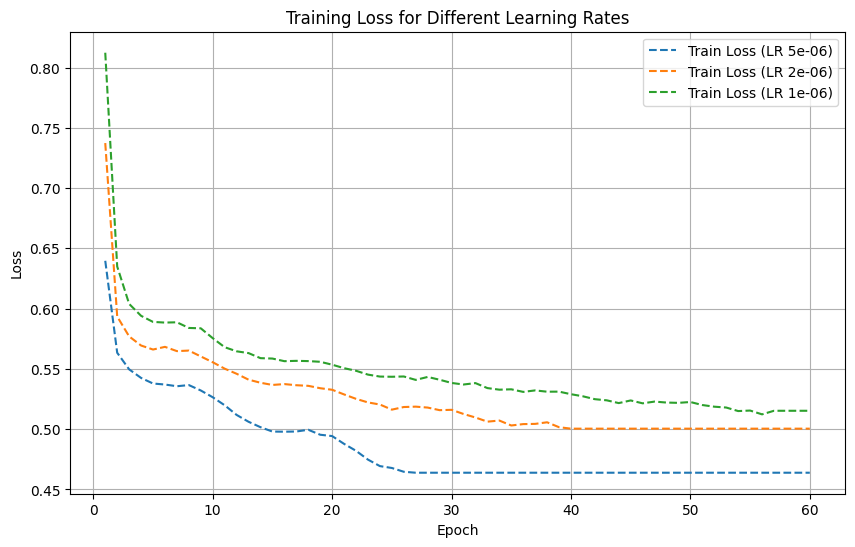

In [31]:
# Plots the results

plt.figure(figsize=(10, 6))

for lr, losses in all_train_losses.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Train Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()


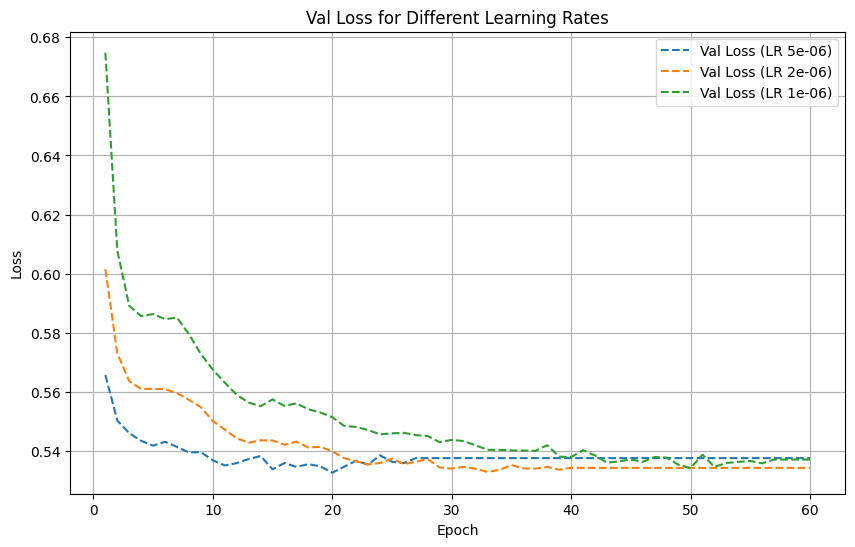

In [33]:
# 📊 Plotando os resultados
plt.figure(figsize=(10, 6))

for lr, losses in all_val_losses.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=f"Val Loss ({lr})", linestyle="dashed")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Val Loss for Different Learning Rates")
plt.legend()
plt.grid()
plt.show()

# Finetuning-Based

In [43]:
os.environ["WANDB_DISABLED"] = "true"

In [36]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [37]:
def compute_metrics(eval_pred):
    """
    Computes accuracy using sklearn's accuracy_score for consistency with other evaluations.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

## Classic

In [50]:
bert = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels = 3)

print_trainable_parameters(bert)

trainable params: 124647939 || all params: 124647939 || trainable%: 100.0


In [51]:
# Define training arguments
training_args = TrainingArguments(
    output_dir=os.path.join(".", 'results_no_LoRA'),
    evaluation_strategy="epoch",
    num_train_epochs=1,
    report_to="none"  # Deactivates wandb
)


# Initialize Trainer
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [52]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.506300,0.509859,0.801492


TrainOutput(global_step=2748, training_loss=0.5738416280288363, metrics={'train_runtime': 1392.0946, 'train_samples_per_second': 15.792, 'train_steps_per_second': 1.974, 'total_flos': 2892142687666176.0, 'train_loss': 0.5738416280288363, 'epoch': 1.0})

In [54]:
# Save the fine-tuned model and configuration
output_dir = os.path.join('.', 'results_no_LoRA')
trainer.model.save_pretrained(output_dir)
trainer.save_model(output_dir)
trainer.model.config.save_pretrained(output_dir)

## LoRA

In [ ]:
# the rank you want to decompose matrices
r = 2
lora_config = LoraConfig(task_type=TaskType.SEQ_CLS, r=r, lora_alpha=1, lora_dropout=0.1)

bert_lora = get_peft_model(bert, lora_config)

In [ ]:
print_trainable_parameters(bert_lora)

trainable params: 73728 || all params: 124719360 || trainable%: 0.05911512053942548


In [ ]:
training_args = TrainingArguments(output_dir=os.path.join(".", 'results_LoRA'),
                                  evaluation_strategy="epoch",
                                  num_train_epochs=1)

# LLM API

In [ ]:

API_KEY = "LA-722439f7298347ab8eeddd84bae652ebc82098f0ae814b4eba9582cf7e8246d6"
URL = "https://api.llama-api.com"

llama = LlamaAPI(API_KEY)

MODEL_NAME = "deepseek-v3"

def classify_tweet(tweet):
    api_request_json = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": "You are a sentiment classifier. Classify the sentiment of the given tweet as [positive, negative, neutral]. Please respond STICTLY with the classes (respect lower casing)"},
            {"role": "user", "content": f"Tweet: {tweet} \n Sentiment: "}
        ],
        "temperature": 0.1
    }

    response = llama.run(api_request_json)

    if response.status_code == 200:
        result = response.json()
        return result["choices"][0]["message"]["content"].strip()  # Retorna a resposta do modelo
    else:
        return f"Erro: {response.status_code}, {response.text}"

In [ ]:
# Let's just use a subset of the full dataset for practical purposes
llama_dataset = train_full.sample(n=10, random_state=42)

In [ ]:
# Listas para armazenar os resultados
true_labels = llama_dataset["Sentiment"].tolist()
predicted_labels = []

for tweet in llama_dataset["Text"]:

    try:
      sentiment = classify_tweet(tweet)
      predicted_labels.append(sentiment)
      print(f"📌 Tweet: {tweet} \n🟢 Predict: {sentiment} \n🔵 Real: {true_labels[len(predicted_labels)-1]}\n")
      time.sleep(2)
    except Exception as e:
        print(f"Error detected: {e}. Waiting 10 seconds before retry ...")
        time.sleep(10)

# Adicionar as previsões ao DataFrame
llama_dataset["Predicted"] = predicted_labels

# Calcular métricas de desempenho
accuracy = accuracy_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["positive", "negative", "neutral"])
report = classification_report(true_labels, predicted_labels, target_names=["positive", "negative", "neutral"])

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

# Plotar matriz de confusão
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "negative", "neutral"],
            yticklabels=["positive", "negative", "neutral"])
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.title(f"Confusion Matrix - Sentiment Analysis ({MODEL_NAME}))")
plt.show()

📌 Tweet:  Enjoy! Family trumps everything 
🟢 Predict: positive 
🔵 Real: positive

📌 Tweet:  --of them kinda turns me off of it all.  And then I buy more of them and dig a deeper hole, etc. ;; 
🟢 Predict: negative 
🔵 Real: negative



KeyboardInterrupt: 

### Fine Tuning with LoRA

In [ ]:
training_args = TrainingArguments(output_dir=os.path.join(".", 'results_LoRA'),
                                  evaluation_strategy="epoch",
                                  num_train_epochs=1)

In [ ]:
# Uses evaluate lib, let's use sklearn accuracy
# To fine tune normally it's the same procedure, but without the get_peft_model & lora_config parts

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.model.save_pretrained(os.path.join(base_dir, 'results_LoRA'))
trainer.save_model(os.path.join(base_dir, 'results_LoRA'))
trainer.model.config.save_pretrained(os.path.join(base_dir, 'results_LoRA'))